# Physical modeling

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 7

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

## Diffusion

Before we get to a Reaction-Diffusion model, we'll start with simple diffusion.

The kernel computes the difference between each cell and the sum of its neighbors.

At each time step, we compute this difference, multiply by a constant, and add it back in to the array.

In [2]:
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d

class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, r=0.1):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        r: diffusion rate constant
        """
        self.r = r
        m = n if m is None else m
        self.array = np.zeros((n, m), np.float)

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c

We don't really have to customize the viewer.

In [3]:
class DiffusionViewer(Cell2DViewer):
    cmap = plt.get_cmap('Reds')

Here's a simple example starting with an "island" of material in the middle.

In [4]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
viewer = DiffusionViewer(diff)

Here's the initial condition:

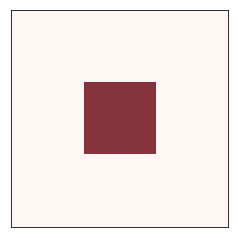

In [5]:
anim = viewer.animate()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.

In [6]:
anim

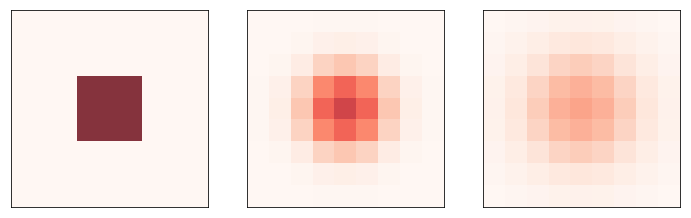

In [7]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
viewer = DiffusionViewer(diff)

thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
viewer.step(5)
viewer.draw()

thinkplot.subplot(3)
viewer.step(10)
viewer.draw()

plt.savefig('chap07-1.pdf')

## Reaction-Diffusion

Now we'll add a second material and let them interact.

The following function helps with setting up the initial conditions.

In [8]:
def island(a, val, noise=None):
    """Adds an island in the middle of the array.
            
    val: height of the island
    noise: magnitude of random noise
    """
    noise = val if noise is None else noise
    n, m = a.shape
    r = min(n, m) // 20
    a[n//2-r:n//2+r, m//2-r:m//2+r] = val
    a += noise * np.random.random((n, m))

For the RD model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

In [9]:
class ReactionDiffusion(Cell2D):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    options = dict(mode='same', boundary='wrap')

    def __init__(self, n, m=None, params=(0.5, 0.25, 0.035, 0.057)):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        params: tuple of (Da, Db, f, k)
        """
        
        self.params = params
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=float)

        self.array2 = np.zeros((n, m), dtype=float)
        island(self.array2, val=0.1, noise=0.1)
        
    def step(self):
        """Executes one time step."""
        A = self.array
        B = self.array2
        ra, rb, f, k = self.params
        
        cA = correlate2d(A, self.kernel, **self.options)
        cB = correlate2d(B, self.kernel, **self.options)
        reaction = A * B**2
        self.array += ra * cA - reaction + f * (1-A) 
        self.array2 += rb * cB + reaction - (f+k) * B

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.

Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

In [10]:
class RDViewer(Cell2DViewer):
    """Generates images and animations."""
    
    cmapu = plt.get_cmap('Reds')
    cmapv = plt.get_cmap('Blues')

    options = dict(alpha=0.7,
                  interpolation='bicubic')
        
    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def draw(self, grid=False):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=100)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

In [11]:
params1 = 0.5, 0.25, 0.035, 0.057   # white spots
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(100, params=params3)
viewer = RDViewer(rd)

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

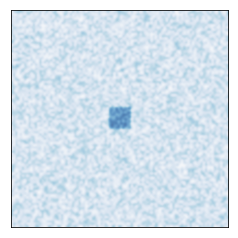

In [12]:
anim = viewer.animate(frames=100)

And here's how it behaves over time.

In [13]:
anim

I'll use the following function to generate figures using different parameters.

In [14]:
def make_viewer(f, k, n=100):
    """Makes a ReactionDiffusion viewer with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params=params)
    viewer = RDViewer(rd)
    return viewer

These parameters yield pink stripes and spots on a blue background:

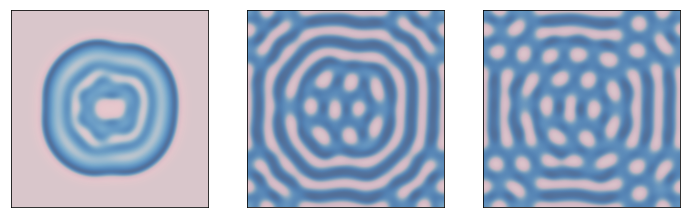

In [15]:
viewer = make_viewer(0.035, 0.057)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-2.pdf')

These parameters yield blue stripes on a pink background.

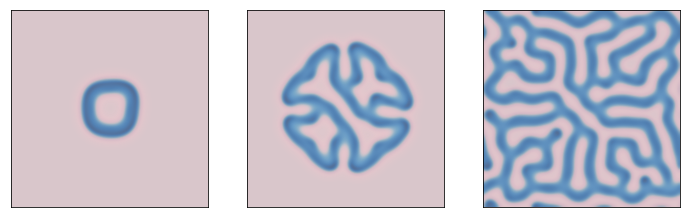

In [16]:
viewer = make_viewer(0.055, 0.062)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-3.pdf')

These parameters yield pink dots on a blue background

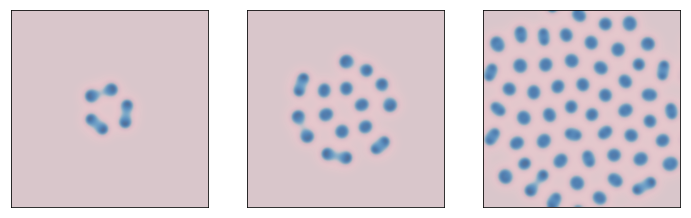

In [17]:
viewer = make_viewer(0.039, 0.065)

thinkplot.preplot(cols=3)
viewer.step(1000)
viewer.draw()

thinkplot.subplot(2)
viewer.step(2000)
viewer.draw()

thinkplot.subplot(3)
viewer.step(4000)
viewer.draw()

plt.savefig('chap07-4.pdf')

## Percolation

In the percolation model, each cell is porous with probability `p`.  We start with a row of wet cells at the time.  During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).  For each value of `p` we compute the probability that water reaches the bottom row.

Porous cells have state `1` and wet cells have state `5`, so if a cell has a wet neighbor, the sum of the neighbors will by `5` or more.


In [18]:
from scipy.signal import correlate2d

class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.5, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        """
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice([0, 1], (n, m), p=[1-p, p])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self, cols=None):
        """Total number of wet cells.
        
        cols: number of columns to select
        """
        a = self.array[:, :cols]
        return np.sum(a == 5)
    
    def num_porous(self, cols=None):
        """Total number of porous cells."""
        a = self.array[:, :cols]
        return np.sum(a == 1)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)

Nothing special about the viewer.

In [19]:
class PercolationViewer(Cell2DViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='none', 
                   vmin=0, vmax=5)

Here an example that shows the first three time steps.

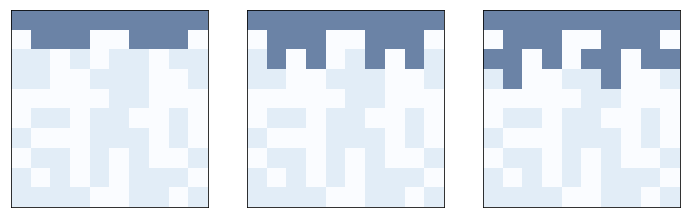

In [20]:
seed = 22
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)

thinkplot.preplot(cols=3)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step()
viewer.draw()

thinkplot.subplot(3)
viewer.step()
viewer.draw()

plt.savefig('chap07-5.pdf')

`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise.

In [21]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: (boolean, number of steps)
    """
    num_wet = perc.num_wet()

    num_steps = 0
    while True:
        perc.step()
        num_steps += 1

        if perc.bottom_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps

        num_wet = new_num_wet

Run a small example with `p=0.5` 

In [22]:
perc = Percolation(10, p=0.5, seed=seed)
flag, num_steps = test_perc(perc)
print(flag, num_steps)

True 11


Here's the initial state:

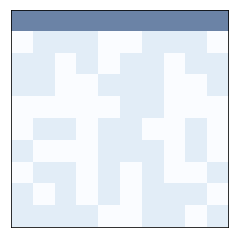

In [23]:
perc = Percolation(10, p=0.5, seed=seed)
viewer = PercolationViewer(perc)
anim = viewer.animate(frames=num_steps+1)

And here's the animation

In [24]:
anim

For a given `p` we can estimate the probability of a percolating cluster by running several random configurations.

In [25]:
def estimate_prob_percolating(p=0.5, n=100, iters=100):
    """Estimates the probability of percolating.
    
    p: probability that a cell is permeable
    n: int number of rows and columns
    iters: number of arrays to test
    
    returns: float probability
    """
    count = 0
    for i in range(iters):
        perc = Percolation(n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            count += 1
        
    return count / iters

At `p=0.55` the probability is low.

In [26]:
fraction = estimate_prob_percolating(p=0.55)
print(fraction)

0.01


At `p=0.6`, the probability is close to 50%, which suggests that the critical value is nearby.

In [27]:
fraction = estimate_prob_percolating(p=0.6)
print(fraction)

0.67


At `p=0.65` the probability is high.

In [28]:
fraction = estimate_prob_percolating(p=0.65)
print(fraction)

1.0


We can search for the critical value by random walk: if there's a percolating cluster, we decrease `p`; otherwise we increase it.

The path should go to the critical point and wander around it.

In [29]:
def find_critical(p=0.6, n=100, iters=100):
    """Estimate p_crit by random walk.
    
    returns: list of p that should wander around p_crit
    """
    ps = [p]
    for i in range(iters):
        perc = Percolation(n=n, p=p)
        flag, _ = test_perc(perc)
        if flag:
            p -= 0.005
        else:
            p += 0.005
        ps.append(p)
    return ps

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

CPU times: user 10.5 s, sys: 4 ms, total: 10.5 s
Wall time: 10.5 s


0.591

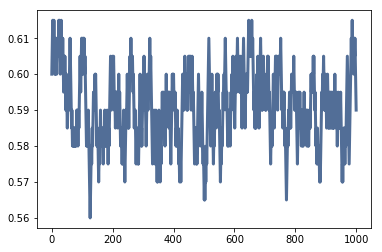

In [30]:
%time ps = find_critical(n=50, iters=1000)
thinkplot.plot(ps)
np.mean(ps)

Larger values of `n` don't seem to change the critical value.

CPU times: user 13.3 s, sys: 12 ms, total: 13.3 s
Wall time: 13.3 s


0.593

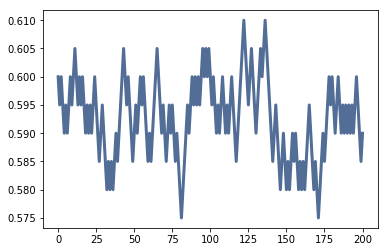

In [31]:
%time ps = find_critical(n=100, iters=200)
thinkplot.plot(ps)
np.mean(ps)

CPU times: user 23.2 s, sys: 0 ns, total: 23.2 s
Wall time: 23.3 s


0.592

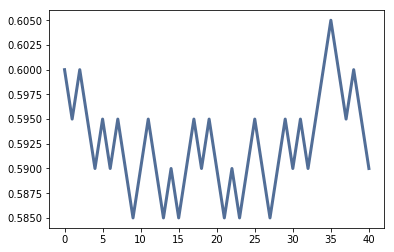

In [32]:
%time ps = find_critical(n=200, iters=40)
thinkplot.plot(ps)
np.mean(ps)

CPU times: user 45.9 s, sys: 4 ms, total: 45.9 s
Wall time: 46 s


0.591

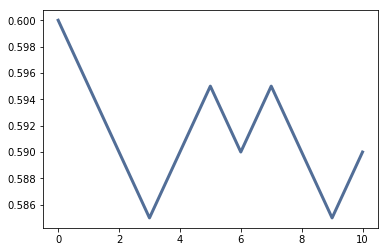

In [33]:
%time ps = find_critical(n=400, iters=10)
thinkplot.plot(ps)
np.mean(ps)

## Fractals

Near the critical point, the cluster of wet cells forms a fractal.  We can see that visually in these examples:

True 138


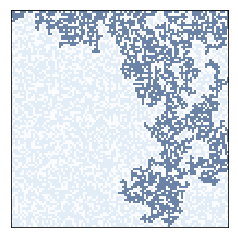

In [34]:
seed = 22
perc1 = Percolation(100, p=0.6, seed=seed)
flag, num_steps = test_perc(perc1)
print(flag, num_steps)
viewer = PercolationViewer(perc1)
viewer.draw()

True 390


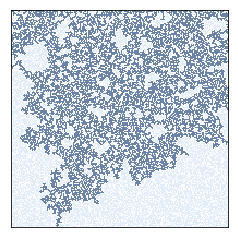

In [35]:
seed = 22
perc2 = Percolation(200, p=0.6, seed=seed)
flag, num_steps = test_perc(perc2)
print(flag, num_steps)
viewer2 = PercolationViewer(perc2)
viewer2.draw()

False 467


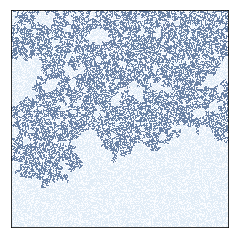

In [36]:
perc3 = Percolation(300, p=0.6, seed=seed)
flag, num_steps = test_perc(perc3)
print(flag, num_steps)
viewer3 = PercolationViewer(perc3)
viewer3.draw()

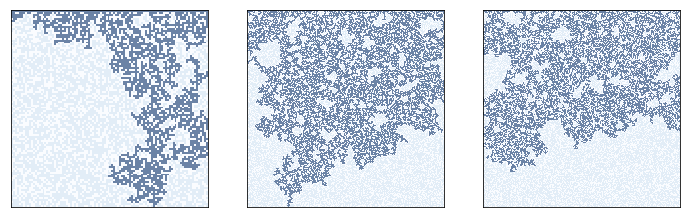

In [37]:
thinkplot.preplot(cols=3)
viewer.draw()

thinkplot.subplot(2)
viewer2.draw()

thinkplot.subplot(3)
viewer3.draw()

plt.savefig('chap07-6.pdf')

To measure fractal dimension, let's start with 1D CAs.

In [38]:
from Cell1D import Cell1D, Cell1DViewer

def draw_ca(rule, n=32):
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    viewer = Cell1DViewer(ca)
    viewer.draw()

Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

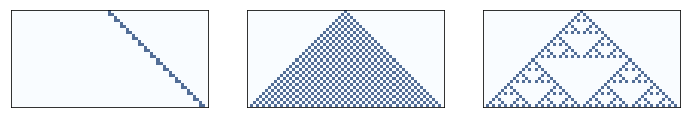

In [39]:
thinkplot.preplot(cols=3)
draw_ca(20)

thinkplot.subplot(2)
draw_ca(50)

thinkplot.subplot(3)
draw_ca(18)

plt.savefig('chap07-7.pdf')

The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.

In [40]:
def count_cells(rule, n=500):
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

This function plots the results, comparing the rate of cell growth to `size` and `size**2`.

And it uses linregress to estimate the slope of the line on a log-log scale.

In [41]:
from scipy.stats import linregress

def test_fractal(rule, ylabel=''):
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    thinkplot.plot(steps, steps2, label='d=2', linestyle='dashed')
    thinkplot.plot(steps, cells, label='rule=%d' % rule)
    thinkplot.plot(steps, steps, label='d=1', linestyle='dashed')

    thinkplot.config(xscale='log', yscale='log',
                     xlabel='time steps', ylabel=ylabel,
                     xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

The linear rule has dimension close to 1.

1.0079212646


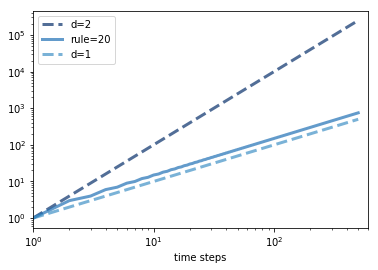

In [42]:
test_fractal(20)

The triangular rule has dimension close to 2.

1.97128088363


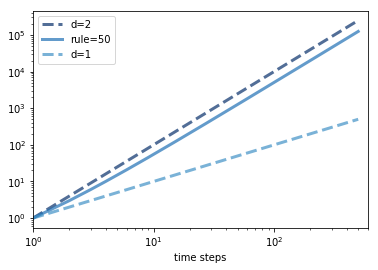

In [43]:
test_fractal(50)

And the Sierpinski triangle has fractal dimension approximately 1.57

1.57392944118


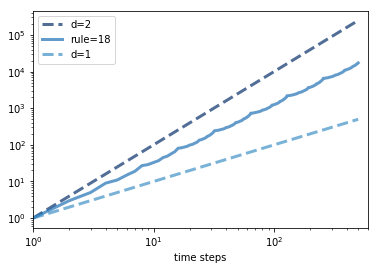

In [44]:
test_fractal(18)

1.0079212646
1.97128088363
1.57392944118


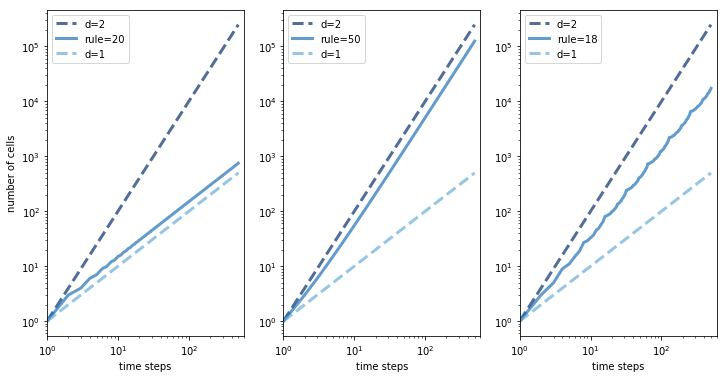

In [45]:
thinkplot.preplot(num=3, cols=3)
test_fractal(20, ylabel='number of cells')

thinkplot.subplot(2)
thinkplot.preplot(num=3)
test_fractal(50)

thinkplot.subplot(3)
thinkplot.preplot(num=3)
test_fractal(18)

plt.savefig('chap07-8.pdf')

Mathematically, the fractal dimension is supposed to be:

In [46]:
np.log(3) / np.log(2)

1.585

## Fractals in percolation models

We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales as we increase the size of a bounding box.

The following function takes a percolation model that has run to completion.  It computes bounding boxes with sizes from 10 up to `n-1`, positioned in the center of the array.

For each bounding box it counts the number of wet cells.

In [47]:
from scipy.stats import linregress

def plot_perc_scaling(sizes, p):
    res = []
    
    for size in sizes:
        perc = Percolation(size, p=p)
        flag, _ = test_perc(perc)
        if flag:
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
        
    sizes, cells, filled = zip(*res)
    
    thinkplot.plot(sizes, cells, label='d=2')
    thinkplot.plot(sizes, filled, label='filled', style='.')
    thinkplot.plot(sizes, sizes, label='d=1')
    
    thinkplot.config(xlabel='size',
                    ylabel='cell count',
                    xscale='log', xlim=[9, 110], 
                    yscale='log', ylim=[9, 20000],
                    loc='top left')
    
    for ys in [cells, filled, sizes]:
        params = linregress(np.log(sizes), np.log(ys))
        print(params[0])

If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.

When `p` is near the critical point, the fractal dimension of the wet cells is near 1.85, but it varies from one run to the next.

2.0
1.83727381586
1.0


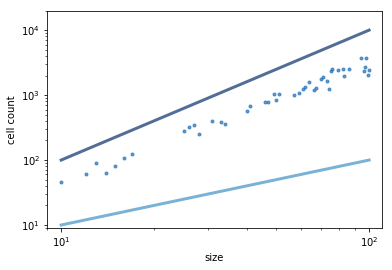

In [48]:
sizes = np.arange(10, 101)
plot_perc_scaling(sizes, p=0.59)

plt.savefig('chap07-9.pdf')

**Exercise:** In Chapter 7 we showed that the Rule 18 CA produces a fractal.
Can you find other rules that produce fractals?  For each one,
estimate its fractal dimension.

Note: the `Cell1D` object in `Cell1D.py` does not wrap around from the left edge to the right, which creates some artifacts at the boundaries.  You might want to use `Wrap1D`, which is a child class of `Cell1D` that wraps around.  It is also defined in `Cell1D.py`.

In [85]:
from Cell1D import Wrap1D
def count_cells_wrap1d(rule, n=500):
    ca = Wrap1D(rule,n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

In [86]:
from scipy.stats import linregress

def test_fractal_no_graph(rule, ylabel=''):
    res = count_cells_wrap1d(rule)
    steps, steps2, cells = zip(*res)
    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        return(params[0])

In [88]:
for rule in range(256):
    slope = test_fractal_no_graph(rule)
    if slope < 1.9 and slope > 1.1:
        print(rule, slope)

18 1.57392944118
22 1.57993794937
26 1.57392944118
60 1.57392944118
78 1.89646115225
82 1.57392944118
90 1.57392944118
92 1.89646115225
102 1.57392944118
109 1.10036348317
126 1.59633225858
139 1.10265975521
143 1.10262818828
146 1.57392944118
150 1.69198163078
151 1.10268183272
154 1.57392944118
155 1.10265569053
159 1.10268183272
169 1.1015698455
171 1.10265975521
173 1.10270234918
175 1.1026707995
183 1.10268183272
185 1.10265975521
187 1.1026707995
189 1.1026707995
191 1.10268183272
201 1.1026638295
203 1.10270234918
205 1.10265975521
207 1.1026707995
209 1.10265975521
210 1.57392944118
211 1.10265569053
213 1.10262818828
215 1.10268183272
217 1.10270234918
218 1.57392944118
219 1.1026707995
221 1.1026707995
223 1.10268183272
225 1.1015698455
227 1.10265975521
229 1.10270234918
231 1.1026707995
233 1.10283809644
235 1.10276687954
237 1.10274488334
239 1.10271335089
241 1.10265975521
243 1.1026707995
245 1.1026707995
247 1.10268183272
249 1.10276687954
251 1.10271335089
253 1.102713

In [52]:
# Solution goes here

In [53]:
# Solution goes here

In [54]:
# Solution goes here

**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

In [160]:
class Percolation_Forest_Fire(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, m=None, p=0.01, f = 0.001, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of empty cell becoming occupied
        f: probability a tree spontaneously burns
        """
        self.p = p
        self.f = f
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        self.array = np.random.choice([0, 1], (n, m), p=[1-p, p])

    def step(self):
        """Executes one time step."""
        a = self.array
        p = self.p
        f = self.f
        c = correlate2d(a, self.kernel, mode='same', boundary='wrap')
        rand = np.random.random(a.shape)
        a[(a==5)] = 0
        a[(a==0) & (rand<p)] = 1
        a[(a==1) & ((c>4) | (rand<f))] = 5
        
    def num_burning(self, cols=None):
        """Total number of wet cells.
        
        cols: number of columns to select
        """
        a = self.array[:, :cols]
        return np.sum(a == 5)
    
    def num_trees(self, cols=None):
        """Total number of porous cells."""
        a = self.array[:, :cols]
        return np.sum(a == 1)

In [136]:
class PercolationViewer(Cell2DViewer):
    """Draws and animates a Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='nearest', 
                   vmin=0, vmax=5)

In [161]:
#from solutions

from matplotlib.colors import LinearSegmentedColormap

class FireViewer(Cell2DViewer):
    vmax = 5
    options = dict(interpolation='nearest', alpha=0.6, 
                   vmin=0, vmax=vmax)
    
    colors = [(0,       'white'),
              (1/vmax,  'Green'),
              (5/vmax,  'Orange')]
    
    cmap = LinearSegmentedColormap.from_list('mycmap', colors)

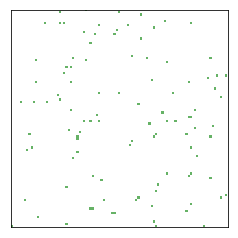

In [162]:
perc = Percolation_Forest_Fire(100)
viewer = FireViewer(perc)
anim = viewer.animate(frames=num_steps+1)

In [163]:
anim

In [165]:
# I don't think I see a fractal in the animation
test_fractal_no_graph(perc.num_trees(), perc.num_burning())
#Don't see a geometry
# fractal dimension is 1.079  and less than 1.1, so maybe not a fractal? 

1.079

In [60]:
# Solution goes here

In [61]:
# Solution goes here

In [62]:
# Solution goes here

In [63]:
# Solution goes here

In [64]:
# Solution goes here